/home/abheekp/YoloV/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.devic

Outputs: {'instances': Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 16.9522, 344.6342, 304.9923, 411.3436],
        [ 24.5931, 505.1324, 494.1706, 637.8845],
        [ 11.2179, 399.9109, 491.8362, 634.2886]], device='cuda:0')), scores: tensor([0.9702, 0.9090, 0.8525], device='cuda:0'), pred_classes: tensor([1, 1, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., 

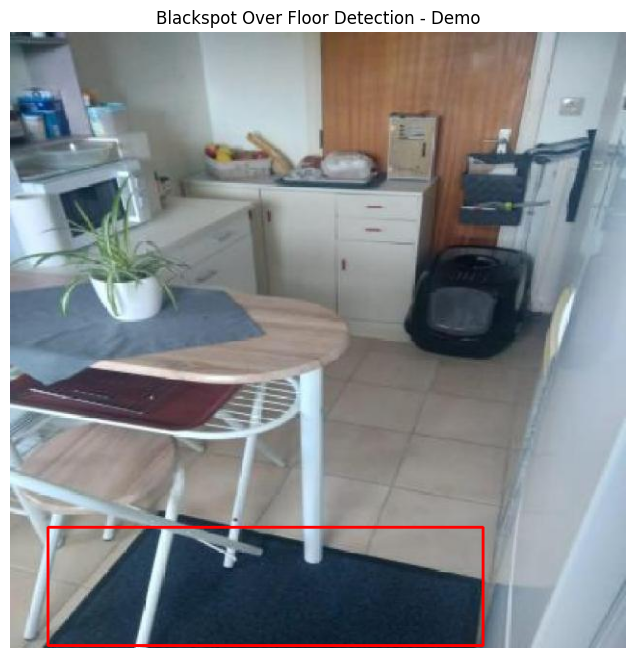

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

# --------------------------------------------------------
# 1. CONFIGURE THE MODEL FOR INFERENCE
# --------------------------------------------------------
cfg = get_cfg()
# Use the model-zoo helper to get a local config file path (do not pass the URI directly)
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = "cuda:0"  # change to "cpu" if you don't have a GPU

# Set the number of classes (must match your training configuration)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # Classes: ["Floors", "blackspot"]

# Point to the final weights saved after training
cfg.MODEL.WEIGHTS = os.path.join("./output_floor_blackspot", "model_final.pth")

# Set the detection threshold for inference
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Create the predictor object for inference
predictor = DefaultPredictor(cfg)

# --------------------------------------------------------
# 2. RUN INFERENCE ON A DEMO IMAGE
# --------------------------------------------------------
demo_img_path = "test/156_jpg.rf.0c323a097eb77ae8ddc9d9d9a32ac615.jpg"
im = cv2.imread(demo_img_path)
if im is None:
    raise ValueError(f"Image not found at {demo_img_path}")

# Run inference
outputs = predictor(im)
print("Outputs:", outputs)
instances = outputs["instances"]

# --------------------------------------------------------
# 3. PROCESS THE OUTPUTS: DRAW BLACKSPOT BOUNDING BOXES ON FLOORS
# --------------------------------------------------------
def get_bbox_from_mask(mask_bool):
    """
    Given a binary mask, returns the bounding box coordinates as (x_min, y_min, x_max, y_max)
    """
    coords = np.argwhere(mask_bool)
    if coords.size == 0:
        return None
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return (x_min, y_min, x_max, y_max)

# Retrieve predicted classes and masks
pred_classes = instances.pred_classes.cpu().numpy()  # class indices (0 for Floors, 1 for blackspot)
pred_masks   = instances.pred_masks.cpu().numpy()    # binary masks

height, width = im.shape[:2]
floor_masks = []
print("Floor_masks" , floor_masks)
blackspot_masks = []
print("Blackspots_masks", floor_masks)

# Separate floor and blackspot masks
for cls_id, mask in zip(pred_classes, pred_masks):
    if cls_id == 0:       # Floors
        floor_masks.append(mask)
    elif cls_id == 1:     # blackspot
        blackspot_masks.append(mask)

# Combine all floor masks into one binary mask
combined_floor_mask = np.any(floor_masks, axis=0) if floor_masks else np.zeros((height, width), dtype=bool)

# For each detected blackspot mask, check if it overlaps with the floor
blackspot_bboxes = []
for bmask in blackspot_masks:
    overlap = bmask & combined_floor_mask
    if overlap.any():
        bbox = get_bbox_from_mask(bmask)
        if bbox is not None:
            blackspot_bboxes.append(bbox)

# Draw bounding boxes on the image
result_img = im.copy()
for (x1, y1, x2, y2) in blackspot_bboxes:
    cv2.rectangle(result_img, (x1, y1), (x2, y2), (0, 0, 255), thickness=2)

# Display the results using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title("Blackspot Over Floor Detection - Demo")
plt.axis("off")
plt.show()


Setting up configuration...
Merging config file from model zoo...
Configuration loaded:
 - Device: cuda:0
 - Number of classes: 2
 - Weights path: ./output_floor_blackspot/model_final.pth
 - Detection threshold: 0.5
Creating predictor...


/home/abheekp/YoloV/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.devic

Predictor created.
Loading demo image from: test/156_jpg.rf.0c323a097eb77ae8ddc9d9d9a32ac615.jpg
Demo image loaded. Image shape: (640, 640, 3)
Running inference...
Inference complete.
 - Number of instances detected: 3
 - Instances details: Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 16.9522, 344.6342, 304.9923, 411.3436],
        [ 24.5931, 505.1324, 494.1706, 637.8845],
        [ 11.2179, 399.9109, 491.8362, 634.2886]], device='cuda:0')), scores: tensor([0.9702, 0.9090, 0.8525], device='cuda:0'), pred_classes: tensor([1, 1, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[

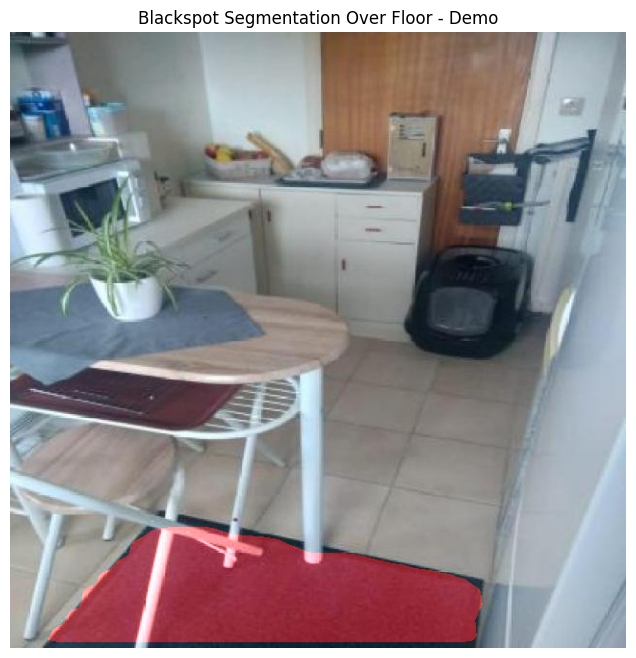

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

# --------------------------------------------------------
# 1. CONFIGURE THE MODEL FOR INFERENCE
# --------------------------------------------------------
print("Setting up configuration...")
cfg = get_cfg()
print("Merging config file from model zoo...")
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = "cuda:0"  # Change to "cpu" if needed

# Set the number of classes (must match your training configuration)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # Classes: ["Floors", "blackspot"]

# Point to the final weights saved after training
weights_path = os.path.join("./output_floor_blackspot", "model_final.pth")
cfg.MODEL.WEIGHTS = weights_path

# Set the detection threshold for inference
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

print("Configuration loaded:")
print(" - Device:", cfg.MODEL.DEVICE)
print(" - Number of classes:", cfg.MODEL.ROI_HEADS.NUM_CLASSES)
print(" - Weights path:", weights_path)
print(" - Detection threshold:", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)

# Create the predictor object for inference
print("Creating predictor...")
predictor = DefaultPredictor(cfg)
print("Predictor created.")

# --------------------------------------------------------
# 2. RUN INFERENCE ON A DEMO IMAGE
# --------------------------------------------------------
demo_img_path = "test/156_jpg.rf.0c323a097eb77ae8ddc9d9d9a32ac615.jpg"
print("Loading demo image from:", demo_img_path)
im = cv2.imread(demo_img_path)
if im is None:
    raise ValueError(f"Image not found at {demo_img_path}")
print("Demo image loaded. Image shape:", im.shape)

print("Running inference...")
outputs = predictor(im)
instances = outputs["instances"]
print("Inference complete.")
print(" - Number of instances detected:", len(instances))
print(" - Instances details:", instances)

# --------------------------------------------------------
# 3. POST-PROCESS THE OUTPUTS FOR SEGMENTATION OVERLAY
# --------------------------------------------------------
# Retrieve predicted classes and masks.
pred_classes = instances.pred_classes.cpu().numpy()  # Class indices (0 for Floors, 1 for blackspot)
pred_masks   = instances.pred_masks.cpu().numpy()    # Binary masks

print("Predicted classes:", pred_classes)
print("Predicted masks shape:", pred_masks.shape)

height, width = im.shape[:2]
floor_masks = []
blackspot_masks = []

print("Separating floor and blackspot masks...")
for i, (cls_id, mask) in enumerate(zip(pred_classes, pred_masks)):
    print(f" - Instance {i}: class id {cls_id}, mask shape {mask.shape}")
    if cls_id == 0:       # Floors
        floor_masks.append(mask)
    elif cls_id == 1:     # Blackspot
        blackspot_masks.append(mask)

print("Number of floor masks:", len(floor_masks))
print("Number of blackspot masks:", len(blackspot_masks))

# Combine all floor masks into one binary mask.
combined_floor_mask = np.any(floor_masks, axis=0) if floor_masks else np.zeros((height, width), dtype=bool)
print("Combined floor mask created. Shape:", combined_floor_mask.shape)

# For each detected blackspot mask, check if it overlaps with the floor.
final_blackspot_mask = np.zeros((height, width), dtype=bool)
for i, bmask in enumerate(blackspot_masks):
    overlap = bmask & combined_floor_mask
    if overlap.any():
        print(f"Blackspot mask {i} overlaps with floor.")
        final_blackspot_mask |= (bmask & combined_floor_mask)
    else:
        print(f"Blackspot mask {i} does not overlap with floor.")

print("Final blackspot mask computed.")

# Create a color overlay for the segmented blackspot regions.
colored_mask = np.zeros((height, width, 3), dtype=np.uint8)
# Red color ([0, 0, 255]) for blackspots.
colored_mask[final_blackspot_mask] = [0, 0, 255]
print("Colored mask created.")

# Overlay the colored mask onto the original image using transparency.
alpha = 0.5  # Adjust transparency: 0 (invisible) to 1 (opaque)
result_img = cv2.addWeighted(im, 1.0, colored_mask, alpha, 0)
print("Segmentation overlay applied.")

# --------------------------------------------------------
# 4. DISPLAY THE SEGMENTATION RESULT
# --------------------------------------------------------
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title("Blackspot Segmentation Over Floor - Demo")
plt.axis("off")
plt.show()


Setting up configuration...
Merging config file from model zoo...
Configuration loaded:
 - Device: cuda:0
 - Number of classes: 2
 - Weights path: ./output_floor_blackspot/model_final.pth
 - Detection threshold: 0.5
Creating predictor...


/home/abheekp/YoloV/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.devic

Predictor created.
Loading demo image from: valid/44_jpg.rf.f27c466da93b0b6450e406385aca0604.jpg
Demo image loaded. Image shape: (640, 640, 3)
Running inference...
Inference complete.
 - Number of instances detected: 3
 - Instances details: Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[2.3977e+00, 4.8748e+02, 3.6766e+02, 6.3894e+02],
        [3.2065e-01, 3.8790e+02, 6.3184e+02, 6.4000e+02],
        [6.6058e+01, 3.9305e+02, 6.4000e+02, 6.3352e+02]], device='cuda:0')), scores: tensor([0.9939, 0.9260, 0.7855], device='cuda:0'), pred_classes: tensor([1, 0, 1], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fal

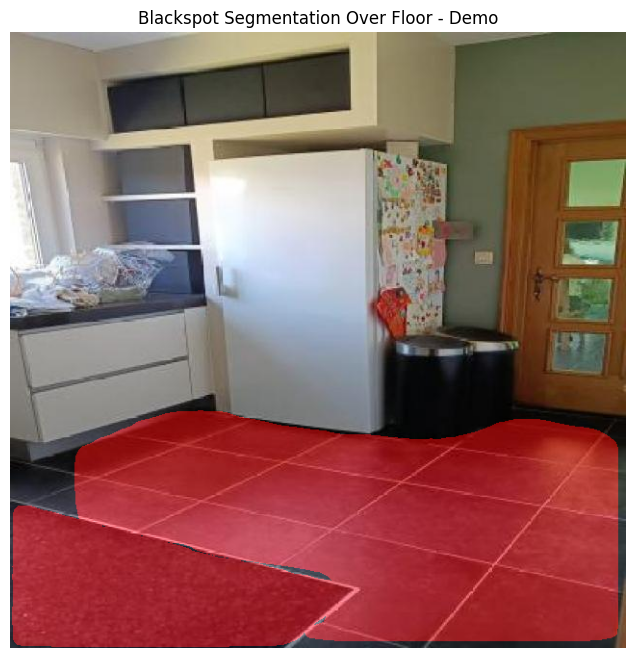

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

# --------------------------------------------------------
# 1. CONFIGURE THE MODEL FOR INFERENCE
# --------------------------------------------------------
print("Setting up configuration...")
cfg = get_cfg()
print("Merging config file from model zoo...")
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = "cuda:0"  # Change to "cpu" if needed

# Set the number of classes (must match your training configuration)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # Classes: ["Floors", "blackspot"]

# Point to the final weights saved after training
weights_path = os.path.join("./output_floor_blackspot", "model_final.pth")
cfg.MODEL.WEIGHTS = weights_path

# Set the detection threshold for inference
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

print("Configuration loaded:")
print(" - Device:", cfg.MODEL.DEVICE)
print(" - Number of classes:", cfg.MODEL.ROI_HEADS.NUM_CLASSES)
print(" - Weights path:", weights_path)
print(" - Detection threshold:", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)

# Create the predictor object for inference
print("Creating predictor...")
predictor = DefaultPredictor(cfg)
print("Predictor created.")

# --------------------------------------------------------
# 2. RUN INFERENCE ON A DEMO IMAGE
# --------------------------------------------------------valid/44_jpg.rf.f27c466da93b0b6450e406385aca0604.jpg
#demo_img_path = "test/156_jpg.rf.0c323a097eb77ae8ddc9d9d9a32ac615.jpg"
demo_img_path ="valid/44_jpg.rf.f27c466da93b0b6450e406385aca0604.jpg" 
print("Loading demo image from:", demo_img_path)
im = cv2.imread(demo_img_path)
if im is None:
    raise ValueError(f"Image not found at {demo_img_path}")
print("Demo image loaded. Image shape:", im.shape)

print("Running inference...")
outputs = predictor(im)
instances = outputs["instances"]
print("Inference complete.")
print(" - Number of instances detected:", len(instances))
print(" - Instances details:", instances)

# --------------------------------------------------------
# 3. POST-PROCESS THE OUTPUTS FOR SEGMENTATION OVERLAY
# --------------------------------------------------------
# Retrieve predicted classes and masks.
pred_classes = instances.pred_classes.cpu().numpy()  # Class indices (0 for Floors, 1 for blackspot)
pred_masks   = instances.pred_masks.cpu().numpy()    # Binary masks

print("Predicted classes:", pred_classes)
print("Predicted masks shape:", pred_masks.shape)

height, width = im.shape[:2]
floor_masks = []
blackspot_masks = []

print("Separating floor and blackspot masks...")
for i, (cls_id, mask) in enumerate(zip(pred_classes, pred_masks)):
    print(f" - Instance {i}: class id {cls_id}, mask shape {mask.shape}")
    if cls_id == 0:       # Floors
        floor_masks.append(mask)
    elif cls_id == 1:     # Blackspot
        blackspot_masks.append(mask)

print("Number of floor masks:", len(floor_masks))
print("Number of blackspot masks:", len(blackspot_masks))

# Combine all floor masks into one binary mask.
combined_floor_mask = np.any(floor_masks, axis=0) if floor_masks else np.zeros((height, width), dtype=bool)
print("Combined floor mask created. Shape:", combined_floor_mask.shape)

# For each detected blackspot mask, check if it overlaps with the floor.
final_blackspot_mask = np.zeros((height, width), dtype=bool)
for i, bmask in enumerate(blackspot_masks):
    overlap = bmask & combined_floor_mask
    if overlap.any():
        print(f"Blackspot mask {i} overlaps with floor.")
        final_blackspot_mask |= (bmask & combined_floor_mask)
    else:
        print(f"Blackspot mask {i} does not overlap with floor.")

print("Final blackspot mask computed.")

# Create a color overlay for the segmented blackspot regions.
colored_mask = np.zeros((height, width, 3), dtype=np.uint8)
# Red color ([0, 0, 255]) for blackspots.
colored_mask[final_blackspot_mask] = [0, 0, 255]
print("Colored mask created.")

# Overlay the colored mask onto the original image using transparency.
alpha = 0.5  # Adjust transparency: 0 (invisible) to 1 (opaque)
result_img = cv2.addWeighted(im, 1.0, colored_mask, alpha, 0)
print("Segmentation overlay applied.")

# --------------------------------------------------------
# 4. DISPLAY THE SEGMENTATION RESULT
# --------------------------------------------------------
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title("Blackspot Segmentation Over Floor - Demo")
plt.axis("off")
plt.show()


/home/abheekp/YoloV/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.devic

Outputs: {'instances': Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[2.3977e+00, 4.8748e+02, 3.6766e+02, 6.3894e+02],
        [3.2065e-01, 3.8790e+02, 6.3184e+02, 6.4000e+02],
        [6.6058e+01, 3.9305e+02, 6.4000e+02, 6.3352e+02]], device='cuda:0')), scores: tensor([0.9939, 0.9260, 0.7855], device='cuda:0'), pred_classes: tensor([1, 0, 1], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [Fal

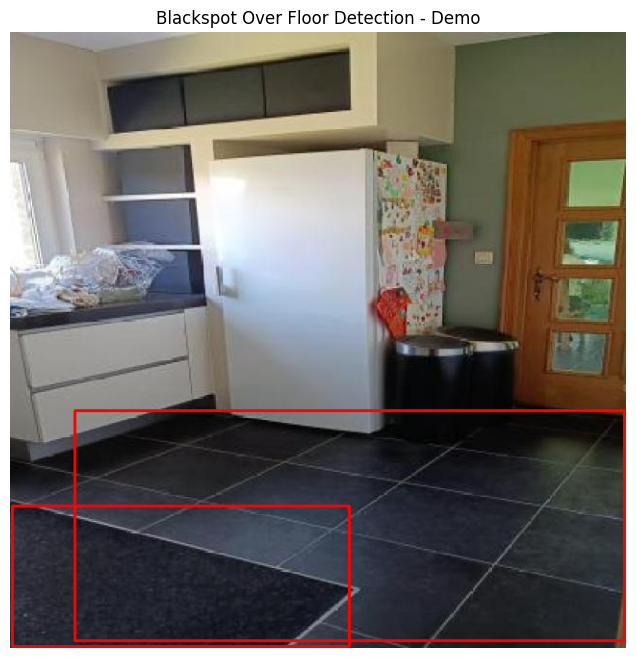

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

# --------------------------------------------------------
# 1. CONFIGURE THE MODEL FOR INFERENCE
# --------------------------------------------------------
cfg = get_cfg()
# Use the model-zoo helper to get a local config file path (do not pass the URI directly)
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = "cuda:0"  # change to "cpu" if you don't have a GPU

# Set the number of classes (must match your training configuration)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # Classes: ["Floors", "blackspot"]

# Point to the final weights saved after training
cfg.MODEL.WEIGHTS = os.path.join("./output_floor_blackspot", "model_final.pth")

# Set the detection threshold for inference
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Create the predictor object for inference
predictor = DefaultPredictor(cfg)

# --------------------------------------------------------
# 2. RUN INFERENCE ON A DEMO IMAGE
# --------------------------------------------------------
demo_img_path = "valid/44_jpg.rf.f27c466da93b0b6450e406385aca0604.jpg"
im = cv2.imread(demo_img_path)
if im is None:
    raise ValueError(f"Image not found at {demo_img_path}")

# Run inference
outputs = predictor(im)
print("Outputs:", outputs)
instances = outputs["instances"]

# --------------------------------------------------------
# 3. PROCESS THE OUTPUTS: DRAW BLACKSPOT BOUNDING BOXES ON FLOORS
# --------------------------------------------------------
def get_bbox_from_mask(mask_bool):
    """
    Given a binary mask, returns the bounding box coordinates as (x_min, y_min, x_max, y_max)
    """
    coords = np.argwhere(mask_bool)
    if coords.size == 0:
        return None
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return (x_min, y_min, x_max, y_max)

# Retrieve predicted classes and masks
pred_classes = instances.pred_classes.cpu().numpy()  # class indices (0 for Floors, 1 for blackspot)
pred_masks   = instances.pred_masks.cpu().numpy()    # binary masks

height, width = im.shape[:2]
floor_masks = []
print("Floor_masks" , floor_masks)
blackspot_masks = []
print("Blackspots_masks", floor_masks)

# Separate floor and blackspot masks
for cls_id, mask in zip(pred_classes, pred_masks):
    if cls_id == 0:       # Floors
        floor_masks.append(mask)
    elif cls_id == 1:     # blackspot
        blackspot_masks.append(mask)

# Combine all floor masks into one binary mask
combined_floor_mask = np.any(floor_masks, axis=0) if floor_masks else np.zeros((height, width), dtype=bool)

# For each detected blackspot mask, check if it overlaps with the floor
blackspot_bboxes = []
for bmask in blackspot_masks:
    overlap = bmask & combined_floor_mask
    if overlap.any():
        bbox = get_bbox_from_mask(bmask)
        if bbox is not None:
            blackspot_bboxes.append(bbox)

# Draw bounding boxes on the image
result_img = im.copy()
for (x1, y1, x2, y2) in blackspot_bboxes:
    cv2.rectangle(result_img, (x1, y1), (x2, y2), (0, 0, 255), thickness=2)

# Display the results using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title("Blackspot Over Floor Detection - Demo")
plt.axis("off")
plt.show()


Setting up configuration...
Merging config file from model zoo...
Configuration loaded:
 - Device: cuda:0
 - Number of classes: 2
 - Weights path: ./output_floor_blackspot/model_final.pth
 - Detection threshold: 0.5
Creating predictor...


/home/abheekp/YoloV/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.devic

Predictor created.
Loading demo image from: valid/44_jpg.rf.f27c466da93b0b6450e406385aca0604.jpg
Demo image loaded. Image shape: (640, 640, 3)
Running inference...
Inference complete.
 - Number of instances detected: 3
 - Instances details: Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[2.3977e+00, 4.8748e+02, 3.6766e+02, 6.3894e+02],
        [3.2065e-01, 3.8790e+02, 6.3184e+02, 6.4000e+02],
        [6.6058e+01, 3.9305e+02, 6.4000e+02, 6.3352e+02]], device='cuda:0')), scores: tensor([0.9939, 0.9260, 0.7855], device='cuda:0'), pred_classes: tensor([1, 0, 1], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fal

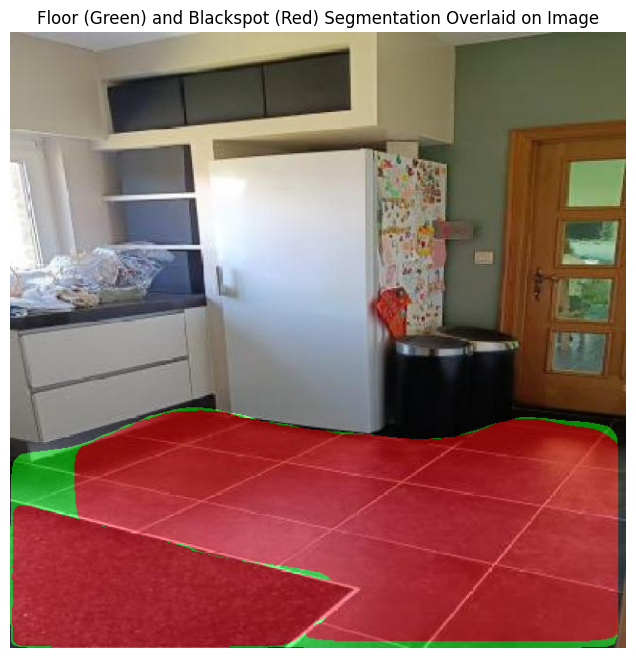

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

# --------------------------------------------------------
# 1. CONFIGURE THE MODEL FOR INFERENCE
# --------------------------------------------------------
print("Setting up configuration...")
cfg = get_cfg()
print("Merging config file from model zoo...")
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = "cuda:0"  # Change to "cpu" if needed

# Set the number of classes (must match your training configuration)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # Classes: ["Floors", "blackspot"]

# Point to the final weights saved after training
weights_path = os.path.join("./output_floor_blackspot", "model_final.pth")
cfg.MODEL.WEIGHTS = weights_path

# Set the detection threshold for inference
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

print("Configuration loaded:")
print(" - Device:", cfg.MODEL.DEVICE)
print(" - Number of classes:", cfg.MODEL.ROI_HEADS.NUM_CLASSES)
print(" - Weights path:", weights_path)
print(" - Detection threshold:", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)

# Create the predictor object for inference
print("Creating predictor...")
predictor = DefaultPredictor(cfg)
print("Predictor created.")

# --------------------------------------------------------
# 2. RUN INFERENCE ON A DEMO IMAGE
# --------------------------------------------------------
demo_img_path = "valid/44_jpg.rf.f27c466da93b0b6450e406385aca0604.jpg"
print("Loading demo image from:", demo_img_path)
im = cv2.imread(demo_img_path)
if im is None:
    raise ValueError(f"Image not found at {demo_img_path}")
print("Demo image loaded. Image shape:", im.shape)

print("Running inference...")
outputs = predictor(im)
instances = outputs["instances"]
print("Inference complete.")
print(" - Number of instances detected:", len(instances))
print(" - Instances details:", instances)

# --------------------------------------------------------
# 3. POST-PROCESS THE OUTPUTS FOR SEGMENTATION OVERLAY
# --------------------------------------------------------
# Retrieve predicted classes and masks.
pred_classes = instances.pred_classes.cpu().numpy()  # Class indices (0 for Floors, 1 for blackspot)
pred_masks   = instances.pred_masks.cpu().numpy()    # Binary masks

print("Predicted classes:", pred_classes)
print("Predicted masks shape:", pred_masks.shape)

height, width = im.shape[:2]
floor_masks = []
blackspot_masks = []

print("Separating floor and blackspot masks...")
for i, (cls_id, mask) in enumerate(zip(pred_classes, pred_masks)):
    print(f" - Instance {i}: class id {cls_id}, mask shape {mask.shape}")
    if cls_id == 0:       # Floors
        floor_masks.append(mask)
    elif cls_id == 1:     # Blackspot
        blackspot_masks.append(mask)

print("Number of floor masks:", len(floor_masks))
print("Number of blackspot masks:", len(blackspot_masks))

# Combine all floor masks into one binary mask.
combined_floor_mask = np.any(floor_masks, axis=0) if floor_masks else np.zeros((height, width), dtype=bool)
print("Combined floor mask created. Shape:", combined_floor_mask.shape)
print("Floor mask pixel count:", np.count_nonzero(combined_floor_mask))

# For each detected blackspot mask, check if it overlaps with the floor.
final_blackspot_mask = np.zeros((height, width), dtype=bool)
for i, bmask in enumerate(blackspot_masks):
    overlap = bmask & combined_floor_mask
    if overlap.any():
        print(f"Blackspot mask {i} overlaps with floor. Overlap pixel count:", np.count_nonzero(overlap))
        final_blackspot_mask |= overlap
    else:
        print(f"Blackspot mask {i} does not overlap with floor.")

print("Final blackspot mask computed.")
print("Blackspot mask pixel count:", np.count_nonzero(final_blackspot_mask))

# Create a colored overlay mask for segmentation.
colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

# Define colors in BGR format (OpenCV uses BGR):
floor_color = [0, 255, 0]      # Green for floor masks
blackspot_color = [0, 0, 255]    # Red for blackspot masks

# Apply floor mask color first.
colored_mask[combined_floor_mask] = floor_color
print("Floor mask applied with color:", floor_color)

# Then apply blackspot mask color (overriding floor color where blackspot exists).
colored_mask[final_blackspot_mask] = blackspot_color
print("Blackspot mask applied with color:", blackspot_color)

# Overlay the colored mask onto the original image using transparency.
alpha = 0.5  # Adjust transparency: 0 (invisible) to 1 (opaque)
result_img = cv2.addWeighted(im, 1.0, colored_mask, alpha, 0)
print("Segmentation overlay applied.")

# --------------------------------------------------------
# 4. DISPLAY THE SEGMENTATION RESULT
# --------------------------------------------------------
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title("Floor (Green) and Blackspot (Red) Segmentation Overlaid on Image")
plt.axis("off")
plt.show()


In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

# --------------------------------------------------------
# 1. CONFIGURE THE MODEL FOR INFERENCE
# --------------------------------------------------------
print("Setting up configuration...")
cfg = get_cfg()
print("Merging config file from model zoo...")
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = "cuda:0"  # Change to "cpu" if needed

# Set the number of classes (must match your training configuration)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # Classes: ["Floors", "blackspot"]

# Point to the final weights saved after training
weights_path = os.path.join("./output_floor_blackspot", "model_final.pth")
cfg.MODEL.WEIGHTS = weights_path

# Set the detection threshold for inference
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

print("Configuration loaded:")
print(" - Device:", cfg.MODEL.DEVICE)
print(" - Number of classes:", cfg.MODEL.ROI_HEADS.NUM_CLASSES)
print(" - Weights path:", weights_path)
print(" - Detection threshold:", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)

# Create the predictor object for inference
print("Creating predictor...")
predictor = DefaultPredictor(cfg)
print("Predictor created.")

# --------------------------------------------------------
# 2. RUN INFERENCE ON A DEMO IMAGE
# --------------------------------------------------------
demo_img_path = "valid/44_jpg.rf.f27c466da93b0b6450e406385aca0604.jpg"
print("Loading demo image from:", demo_img_path)
im = cv2.imread(demo_img_path)
if im is None:
    raise ValueError(f"Image not found at {demo_img_path}")
print("Demo image loaded. Image shape:", im.shape)

print("Running inference...")
outputs = predictor(im)
instances = outputs["instances"]
print("Inference complete.")
print(" - Number of instances detected:", len(instances))
print(" - Instances details:", instances)

# --------------------------------------------------------
# 3. OUTPUT ONLY ONE TENSOR: PREDICTED MASKS
# --------------------------------------------------------
# Here, we extract only the predicted masks tensor.
predicted_masks = instances.pred_masks  # This tensor contains the segmentation masks for each instance.
print("Predicted masks tensor:")
print(predicted_masks)

# Optionally, if you want to convert it to a NumPy array for further processing or inspection:
predicted_masks_np = predicted_masks.cpu().numpy()
print("Predicted masks as a NumPy array with shape:", predicted_masks_np.shape)


Setting up configuration...
Merging config file from model zoo...
Configuration loaded:
 - Device: cuda:0
 - Number of classes: 2
 - Weights path: ./output_floor_blackspot/model_final.pth
 - Detection threshold: 0.5
Creating predictor...


/home/abheekp/YoloV/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.devic

Predictor created.
Loading demo image from: valid/44_jpg.rf.f27c466da93b0b6450e406385aca0604.jpg
Demo image loaded. Image shape: (640, 640, 3)
Running inference...
Inference complete.
 - Number of instances detected: 3
 - Instances details: Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[2.3977e+00, 4.8748e+02, 3.6766e+02, 6.3894e+02],
        [3.2065e-01, 3.8790e+02, 6.3184e+02, 6.4000e+02],
        [6.6058e+01, 3.9305e+02, 6.4000e+02, 6.3352e+02]], device='cuda:0')), scores: tensor([0.9939, 0.9260, 0.7855], device='cuda:0'), pred_classes: tensor([1, 0, 1], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fal

Setting up configuration...
Merging config file from model zoo...
Configuration loaded:
 - Device: cuda:0
 - Number of classes: 2
 - Weights path: ./output_floor_blackspot/model_final.pth
 - Detection threshold: 0.5
Creating predictor...


/home/abheekp/YoloV/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.devic

Predictor created.
Loading demo image from: valid/44_jpg.rf.f27c466da93b0b6450e406385aca0604.jpg
Demo image loaded. Image shape: (640, 640, 3)

--- Base64 Encoded Image ---
/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAKAAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxE

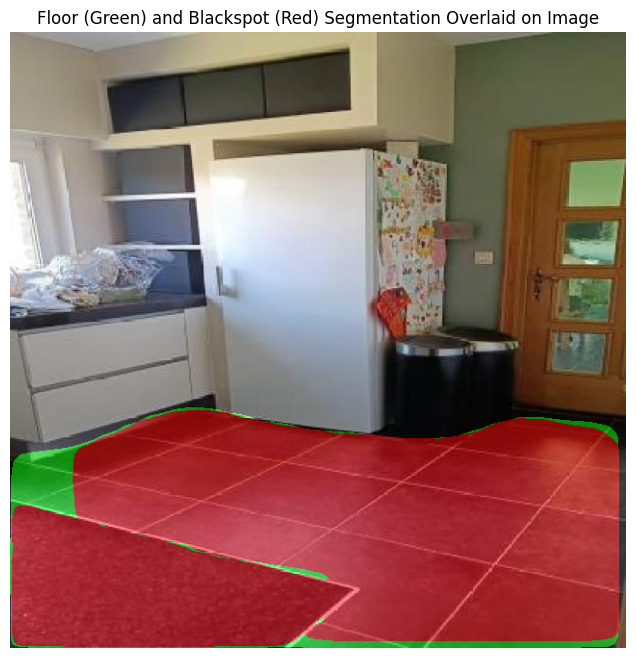

In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import base64

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

# --------------------------------------------------------
# 1. CONFIGURE THE MODEL FOR INFERENCE
# --------------------------------------------------------
print("Setting up configuration...")
cfg = get_cfg()
print("Merging config file from model zoo...")
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = "cuda:0"  # Change to "cpu" if needed

# Set the number of classes (must match your training configuration)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # Classes: ["Floors", "blackspot"]

# Point to the final weights saved after training
weights_path = os.path.join("./output_floor_blackspot", "model_final.pth")
cfg.MODEL.WEIGHTS = weights_path

# Set the detection threshold for inference
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

print("Configuration loaded:")
print(" - Device:", cfg.MODEL.DEVICE)
print(" - Number of classes:", cfg.MODEL.ROI_HEADS.NUM_CLASSES)
print(" - Weights path:", weights_path)
print(" - Detection threshold:", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)

print("Creating predictor...")
predictor = DefaultPredictor(cfg)
print("Predictor created.")

# --------------------------------------------------------
# 2. LOAD, ENCODE TO BASE64, PRINT, AND DECODE THE IMAGE
# --------------------------------------------------------
demo_img_path = "valid/44_jpg.rf.f27c466da93b0b6450e406385aca0604.jpg"
print("Loading demo image from:", demo_img_path)
im = cv2.imread(demo_img_path)
if im is None:
    raise ValueError(f"Image not found at {demo_img_path}")
print("Demo image loaded. Image shape:", im.shape)

# Encode the image to JPEG and then to base64
retval, buffer = cv2.imencode('.jpg', im)
im_base64 = base64.b64encode(buffer).decode('utf-8')
print("\n--- Base64 Encoded Image ---")
print(im_base64)
print("--- End of Base64 Encoded Image ---\n")

# For demonstration, decode the base64 string back into an image
img_data = base64.b64decode(im_base64)
nparr = np.frombuffer(img_data, np.uint8)
im_decoded = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
print("Decoded image shape:", im_decoded.shape)

# --------------------------------------------------------
# 3. RUN INFERENCE ON THE DECODED IMAGE
# --------------------------------------------------------
print("Running inference on decoded image...")
outputs = predictor(im_decoded)
instances = outputs["instances"]
print("Inference complete.")
print(" - Number of instances detected:", len(instances))
print(" - Instances details:", instances)

# --------------------------------------------------------
# 4. POST-PROCESS THE OUTPUTS FOR SEGMENTATION OVERLAY
# --------------------------------------------------------
# Retrieve predicted classes and masks.
pred_classes = instances.pred_classes.cpu().numpy()  # Class indices (0 for Floors, 1 for blackspot)
pred_masks   = instances.pred_masks.cpu().numpy()    # Binary masks

print("Predicted classes:", pred_classes)
print("Predicted masks shape:", pred_masks.shape)

height, width = im_decoded.shape[:2]
floor_masks = []
blackspot_masks = []

print("Separating floor and blackspot masks...")
for i, (cls_id, mask) in enumerate(zip(pred_classes, pred_masks)):
    print(f" - Instance {i}: class id {cls_id}, mask shape {mask.shape}")
    if cls_id == 0:       # Floors
        floor_masks.append(mask)
    elif cls_id == 1:     # Blackspot
        blackspot_masks.append(mask)

print("Number of floor masks:", len(floor_masks))
print("Number of blackspot masks:", len(blackspot_masks))

# Combine all floor masks into one binary mask.
combined_floor_mask = np.any(floor_masks, axis=0) if floor_masks else np.zeros((height, width), dtype=bool)
print("Combined floor mask created. Shape:", combined_floor_mask.shape)
print("Floor mask pixel count:", np.count_nonzero(combined_floor_mask))

# For each detected blackspot mask, check if it overlaps with the floor.
final_blackspot_mask = np.zeros((height, width), dtype=bool)
for i, bmask in enumerate(blackspot_masks):
    overlap = bmask & combined_floor_mask
    if overlap.any():
        print(f"Blackspot mask {i} overlaps with floor. Overlap pixel count:", np.count_nonzero(overlap))
        final_blackspot_mask |= overlap
    else:
        print(f"Blackspot mask {i} does not overlap with floor.")

print("Final blackspot mask computed.")
print("Blackspot mask pixel count:", np.count_nonzero(final_blackspot_mask))

# Create a colored overlay mask for segmentation.
colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

# Define colors in BGR format (OpenCV uses BGR):
floor_color = [0, 255, 0]      # Green for floor masks
blackspot_color = [0, 0, 255]    # Red for blackspot masks

# Apply floor mask color first.
colored_mask[combined_floor_mask] = floor_color
print("Floor mask applied with color:", floor_color)

# Then apply blackspot mask color (overriding floor color where blackspot exists).
colored_mask[final_blackspot_mask] = blackspot_color
print("Blackspot mask applied with color:", blackspot_color)

# Overlay the colored mask onto the original image using transparency.
alpha = 0.5  # Transparency factor: 0 (invisible) to 1 (opaque)
result_img = cv2.addWeighted(im_decoded, 1.0, colored_mask, alpha, 0)
print("Segmentation overlay applied.")

# --------------------------------------------------------
# 5. DISPLAY THE FINAL RESULT
# --------------------------------------------------------
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title("Floor (Green) and Blackspot (Red) Segmentation Overlaid on Image")
plt.axis("off")
plt.show()
